Определение индекса популярности банкоматов.

In [1]:
# обработка
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# моделирование
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

# оценка
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# корень из среднеквадратичной ошибки

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

### 1. Загрузка и подготовка данных

In [3]:
train = pd.read_csv('D:\\Work\\data\\bank\\train.csv', index_col = 0)
test = pd.read_csv('D:\\Work\\data\\bank\\test.csv', index_col = 0)

train['isTrain'] = True
test['isTrain'] = False

In [4]:
X = train.append(test, sort=False)

In [5]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8765.0,4404.586366,2542.532548,1.000000,2207.000000,4403.000000,6603.000000,8811.000000
atm_group,8765.0,4407.008842,2427.934099,32.000000,1942.000000,5478.000000,5478.000000,8083.000000
lat,8345.0,54.138304,4.329293,42.057080,52.243997,55.060936,56.116673,69.495093
long,8345.0,63.500873,32.787366,19.941530,37.851107,49.071694,84.950218,173.706490
target,6261.0,0.000715,0.085852,-0.145001,-0.061176,-0.015573,0.040149,0.218608


In [6]:
X.describe(include='object').T

,count,unique,top,freq
address,8765,7481,"HOROSHEVSKOE SH,V38 MOSKVA",7
address_rus,8345,6147,"квартал В-13, городской округ Волгодонск, Рост...",10


Расчет кол-ва банкоматов по одному адресу:

In [7]:
counts = X.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'count'})

In [8]:
X = pd.merge(X, counts, how='left', on='address_rus')

In [9]:
X.head()

,id,atm_group,address,address_rus,lat,long,target,isTrain,count
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,True,1.0
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,True,1.0
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,True,1.0
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,True,1.0
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,True,1.0


Расчет расстояния до ближайших банкоматов:

In [10]:
R = 6373.0 # радиус Земли в км

def distance(x, y):
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y]) # x - широта и долгота первой гео, y - широта и долгота второй гео 
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c # дистанция в км между гео

### 2. Поиск ближайших друг к другу банкоматов

In [11]:
# расчет по методу ближайших соседей

knc = KNeighborsClassifier(metric = distance) 

In [12]:
dots = X[['lat', 'long']].dropna()

In [13]:
knc.fit(X = dots, y = np.ones(dots.shape[0])) # расчет по широте и долготе

KNeighborsClassifier(metric=<function distance at 0x000001DBF024D700>)

In [14]:
distances, indexes = knc.kneighbors(X = dots, n_neighbors = 6) # определеяем близость по 6 соседям

In [15]:
for i in range(1, 6):
    dots['distance_%s'%i] = distances[:, i]
    dots['indexes_%s'%i] = indexes[:, i]

In [16]:
dots['mean'] = dots.iloc[:, dots.columns.str.contains('distance')].mean(axis=1)

In [17]:
X = pd.concat([X, dots], axis=1)

Город размещения:

In [18]:
X['city'] = X[~X.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[2]) # выделение 3й сущности (город) после зпт в столбце address_rus

In [19]:
rare_cities = X.city.value_counts()[(X.city.value_counts() < 20) == True].index # редко встречающиейся города

In [20]:
X['city'] = X['city'].apply(lambda x: 'RARE' if x in rare_cities else x) 

In [21]:
X['city'] = X['city'].rank().fillna(-1)

In [22]:
X_ = X[X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                    'distance_2',  'distance_3',  'distance_4', 'distance_5',
                    'indexes_5', 'mean', 'city']] # переменные для расчета
X_ = X_.loc[:, ~X_.columns.duplicated()]
Y_ = X.loc[X.isTrain, 'target']

In [23]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.25, random_state=1)

### 3. Обучение моделей

In [24]:
gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 4,
                            colsample_bytre = 0.85,
                            subsample = 0.85, 
                            learning_rate = 0.15,
                            n_estimators = 280)

gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=7)

[LightGBM] [Warning] Unknown parameter: colsample_bytre
[1]	valid_0's rmse: 0.076371	valid_0's l2: 0.00583253
Training until validation scores don't improve for 7 rounds
[2]	valid_0's rmse: 0.0697908	valid_0's l2: 0.00487076
[3]	valid_0's rmse: 0.0646181	valid_0's l2: 0.00417549
[4]	valid_0's rmse: 0.0603726	valid_0's l2: 0.00364485
[5]	valid_0's rmse: 0.0571123	valid_0's l2: 0.00326182
[6]	valid_0's rmse: 0.054649	valid_0's l2: 0.00298651
[7]	valid_0's rmse: 0.0528328	valid_0's l2: 0.0027913
[8]	valid_0's rmse: 0.051327	valid_0's l2: 0.00263446
[9]	valid_0's rmse: 0.0502312	valid_0's l2: 0.00252317
[10]	valid_0's rmse: 0.0494199	valid_0's l2: 0.00244232
[11]	valid_0's rmse: 0.0487256	valid_0's l2: 0.00237418
[12]	valid_0's rmse: 0.0482764	valid_0's l2: 0.00233061
[13]	valid_0's rmse: 0.0477937	valid_0's l2: 0.00228424
[14]	valid_0's rmse: 0.0474181	valid_0's l2: 0.00224848
[15]	valid_0's rmse: 0.0471956	valid_0's l2: 0.00222743
[16]	valid_0's rmse: 0.0469502	valid_0's l2: 0.00220432
[

LGBMRegressor(colsample_bytre=0.85, learning_rate=0.15, max_depth=4,
              n_estimators=280, objective='regression', subsample=0.85)

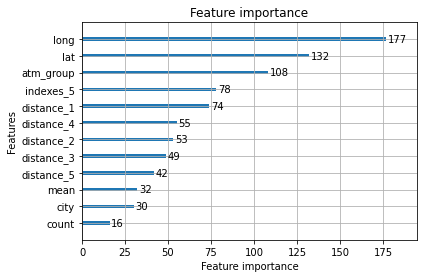

In [25]:
# значение переменных
lgb.plot_importance(gbm)

In [26]:
print('Sqrt RMSE predict:', rmse(Y_valid, gbm.predict(X_valid)))
print('Sqrt RMSE valid:', rmse(Y_valid, np.zeros(Y_valid.shape[0])))

Sqrt RMSE predict: 0.04530724803670742
Sqrt RMSE valid: 0.08463725683992336


In [27]:
X_test = X[~X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                        'distance_2', 'distance_3',  'distance_4', 'distance_5',
                        'indexes_5', 'mean', 'city']]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

In [28]:
submit = pd.DataFrame(gbm.predict(X_test), index=test.index, columns=['target'])

In [29]:
submit.to_csv('D:\\Work\\data\\bank\\submit.csv')